In [1]:
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

from processing.RANSAC import get_codirectional_lines

In [2]:
image = cv2.imread('images/obl6.jpg')
image.shape

(2914, 2353, 3)

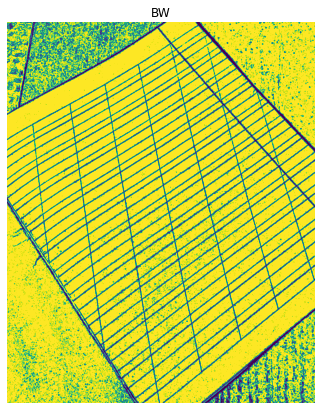

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
dilated = cv2.morphologyEx(gray, cv2.MORPH_DILATE, kernel)
median = cv2.medianBlur(dilated, 5)
diff2 = 255 - cv2.subtract(median, gray)
normed = cv2.normalize(diff2,None, 10, 255, cv2.NORM_MINMAX )
bw = cv2.threshold(normed, 245, 255, cv2.THRESH_BINARY)[1]
edges = cv2.Canny(bw, 200, 120, apertureSize=3, L2gradient=True)

plt.figure(figsize=(7,7))
plt.clf()
plt.axis("off")
plt.title("BW")
plt.imshow(bw)

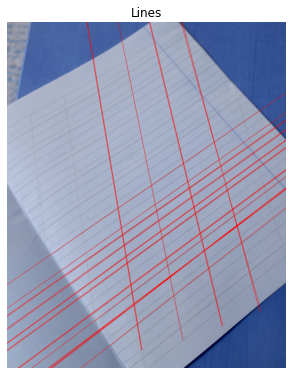

In [9]:
lines = cv2.HoughLines(edges, 1, np.pi/360, 650,)
lines_points = np.empty((len(lines), 4), dtype=int)
lines_coefs = np.empty((len(lines), 3))
coef = max(image.shape)

for i, line in enumerate(lines):
    for rho, theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + coef*(-b))
        y1 = int(y0 + coef*(a))
        x2 = int(x0 - coef*(-b))
        y2 = int(y0 - coef*(a))
        lines_points[i] = (x1, y1, x2, y2)
        lines_coefs[i] = np.cross((x1, y1, 1), (x2, y2, 1))
        
img_copy = image.copy()
for i, (x1, y1, x2, y2) in enumerate(lines_points):
    cv2.line(img_copy, (x1, y1), (x2, y2), (255, 0, 0),2)
    
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)  

In [10]:
print(f"found lines: {len(lines_coefs)}")  
line_group1, mask, v_point1 = get_codirectional_lines(lines_coefs, iters=2000, epsilon=0.05)
print(f"lines in group 1: {len(line_group1)}")
lines_points1 = lines_points[mask]

found lines: 25
lines in group 1: 17


In [11]:
lines_points = lines_points[~mask]
line_group2, mask, v_point2 = get_codirectional_lines(lines_coefs[~mask], iters=2000, epsilon=0.05)
print(f"lines in group 2: {len(line_group2)}")
lines_points2 = lines_points[mask]

lines in group 2: 6


In [12]:
vanish_temp_norm = (np.cross([ -418.,  7988., 15976.], [ 7.9210000e+03,  1.1140000e+03, -2.3489337e+07])/
     np.linalg.norm(np.cross([ -418.,  7988., 15976.], [ 7.9210000e+03,  1.1140000e+03, -2.3489337e+07])))
    
cross_points_norm = (np.cross([ -418.,  7988., 15976.], [ 6.1270000e+03,  5.1410000e+03, -1.7985073e+07])/
     np.linalg.norm(np.cross([ -418.,  7988., 15976.], [ 6.1270000e+03,  5.1410000e+03, -1.7985073e+07])))

np.arccos(np.abs(np.dot(vanish_temp_norm, cross_points_norm)))

3.515604910517499e-05

### Check found lines

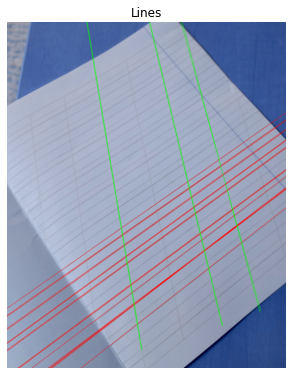

In [14]:
img_copy = image.copy()
    
for i, (x1, y1, x2, y2) in enumerate(lines_points1):
    if abs(v_point1[0]/v_point1[1]) > 1:
        cv2.line(img_copy, (x1, y1), (x2, y2), (255,0,0),2)
    else:
        cv2.line(img_copy, (x1, y1), (x2, y2), (0,0, 255),2)
for i, (x1, y1, x2, y2) in enumerate(lines_points2):
    if abs(v_point2[0]/v_point2[1]) < 1:
        cv2.line(img_copy, (x1, y1), (x2, y2), (0,255,0),2)
    else:
        cv2.line(img_copy, (x1, y1), (x2, y2), (0,0, 255),2)

plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)  

### Perspective Transform functions

In [15]:
def find_axis_points(v_inf1, v_inf2):  
    
    v_inf1 = v_inf1 / np.linalg.norm(v_inf1)
    v_inf2 = v_inf2 / np.linalg.norm(v_inf2)
    
    #set all possible directions of vp
    dirs = np.array([[v_inf1[0], -v_inf1[0], v_inf2[0], -v_inf2[0]],
                    [v_inf1[1], -v_inf1[1], v_inf2[1], -v_inf2[1]],
                    [v_inf1[2], -v_inf1[2], v_inf2[2], -v_inf2[2]]]) 
    
    #calculate angles between Ox and each point
    thetas = np.arctan2(dirs[1], dirs[0])
    #get idx of a point that is the most closest to +Ox axis 
    horisont_vp_idx = np.argmin(np.abs(thetas)) 
    #get idx the most closest to +Oy axis point
    if horisont_vp_idx//2 == 0:
        vertical_vp_idx = 2 + np.argmax(thetas[2:])
    else:
        vertical_vp_idx = np.argmax(thetas[:2])
    
#     print(f'points idxs:   h - {horisont_vp_idx}, v - {vertical_vp_idx}')    
    hor_v_point = dirs[:, horisont_vp_idx]
    vert_v_point = dirs[:, vertical_vp_idx] 
    return hor_v_point, vert_v_point



def find_horizontal_vp(v_inf1, v_inf2):  
    
    v_inf1 = v_inf1 / np.linalg.norm(v_inf1)
    v_inf2 = v_inf2 / np.linalg.norm(v_inf2)
    
    #set all possible directions of vp
    dirs = np.array([[v_inf1[0], -v_inf1[0], v_inf2[0], -v_inf2[0]],
                    [v_inf1[1], -v_inf1[1], v_inf2[1], -v_inf2[1]],
                    [v_inf1[2], -v_inf1[2], v_inf2[2], -v_inf2[2]]]) 
    
    #calculate angles between Ox and each point
    thetas = np.arctan2(dirs[1], dirs[0])
    #get idx of a point that is the most closest to +Ox axis 
    horisont_vp_idx = np.argmin(np.abs(thetas)) 
    #get idx the most closest to +Oy axis point
    if horisont_vp_idx//2 == 0:
        vertical_vp_idx = 2 + np.argmax(thetas[2:])
    else:
        vertical_vp_idx = np.argmax(thetas[:2])
    return horisont_vp_idx//2    

In [16]:
def find_homography(hor_point, vert_point, intersec_angle_degrees, shift=None, im_shape=None):
    #rotate the vertical v.p. to get pi/2 angle between horizontal v.p. and vertical v.p.
    rotate_angle = math.radians(90-intersec_angle_degrees)
    cs = np.cos(rotate_angle);
    sn = np.sin(rotate_angle);  
    vert_point_new = [
        vert_point[0] * cs + vert_point[1] * sn,
        vert_point[1] * cs - vert_point[0] * sn,
        vert_point[2]
    ]
    #find homography
    H = np.eye(3)
    H[0] = np.cross(vert_point_new, np.cross(hor_point, vert_point_new)) 
    H[1] = np.cross(np.cross(hor_point, vert_point_new), hor_point)
    H[2] = np.cross(hor_point, vert_point_new)
    
    if np.linalg.det(H) < 0:
        H[:, 0] = -H[:, 0]
    
    if shift:
        T = np.array([
            [1., 0., -float(im_shape[0])/2],
            [0., 1., -float(im_shape[1])/2],
            [0., 0.,   1.]
        ])
        T_1 = np.linalg.inv(T)
        H = np.matmul(T_1, H, T)
    return H

In [17]:
def transform_points(points, homography):
    #transform a list of points in projection plane
    points_new = np.zeros(points.shape)
    for i, point in enumerate(points):
        points_new[i] = np.matmul(homography, point)
    return (points_new/points_new[:, 2][:, None])[:, :2]


def _find_corner_points(lines1, lines2, vp1, vp2):
    if find_horizontal_vp(vp1, vp2) == 0:
#       order must be changed
        horizontal = lines1
        vertical = lines2
    else:
#       order must be changed
        horizontal = lines2
        vertical = lines1
    l1 = horizontal[(-horizontal[:, 2]/horizontal[:, 1]).argmin()] #y-intercept - top
    l2 = vertical[(-vertical[:, 2]/vertical[:, 0]).argmin()] #x-intercept - left
    l3 = horizontal[(-horizontal[:, 2]/horizontal[:, 1]).argmax()] #x-intercept - bottom
    l4 = vertical[(-vertical[:, 2]/vertical[:, 0]).argmax()] #y-intercept - right
    corner_points = np.cross([l1, l2, l3, l4], [l2, l3, l4, l1])
    return (corner_points/corner_points[:, 2][:, None])

### Transformation

In [18]:
hor_point, vert_point = find_axis_points(v_point1, v_point2)
# point order must be changed
homography = find_homography( hor_point, vert_point, 60, shift=True, im_shape=image.shape[:2])


img_shape=(image.shape[1], image.shape[0])
img_corners = np.array([[0, 0, 1], [0, img_shape[1], 1], [*img_shape, 1], [img_shape[0], 0, 1]])
img_corners_transformed = transform_points(img_corners, homography)

#find bounding box and its shape
min_x = np.min(img_corners_transformed[:, 0])
max_x = np.max(img_corners_transformed[:, 0])
min_y = np.min(img_corners_transformed[:, 1])
max_y = np.max(img_corners_transformed[:, 1])
bounding_box = np.array([
    [min_x, min_y],
    [min_x, max_y],
    [max_x, max_y],
    [max_x, min_y]
])
new_image_shape = (int(max_x - min_x), int(max_y - min_y))

#move bounding box to the left upper corner
srcpts = np.float32([bounding_box])
destpts = np.float32([[0, 0], [0, new_image_shape[1]], new_image_shape, [new_image_shape[0], 0]])
resmatrix = cv2.getPerspectiveTransform(srcpts, destpts)
#find full transformation homography
full_homography = resmatrix.dot(homography)

#transform and save image
img_new_1 = cv2.warpPerspective(image, full_homography, new_image_shape)
# cv2.imwrite('./images/results/rectified_img.png', img_new_1)

#additional step. crop image by most extreme lines
corners = _find_corner_points(lines1=line_group1, lines2=line_group2, vp1=v_point1, vp2=v_point2)
sheet_corners = transform_points(corners, full_homography)

#the followinf step is only for oblique lines in order to catch a square area
x_left = min(sheet_corners[0][0], sheet_corners[1][0])
y_bottom = max(sheet_corners[1][1], sheet_corners[2][1])
x_right = max(sheet_corners[2][0], sheet_corners[3][0])
y_top = min(sheet_corners[3][1], sheet_corners[0][1])
sheet_corners = np.array(
[
    [x_left, y_top],
    [x_left, y_bottom],
    [x_right, y_bottom],
    [x_right, y_top]
])
new_image_shape = (int(x_right - x_left), int(y_bottom - y_top))

#get homography, transform and save image
srcpts = np.float32([sheet_corners])
destpts = np.float32([[0, 0], [0, new_image_shape[1]], new_image_shape, [new_image_shape[0], 0]])
resmatrix = cv2.getPerspectiveTransform(srcpts, destpts)
img_new_2 = cv2.warpPerspective(img_new_1, resmatrix, new_image_shape)
# cv2.imwrite('./images/results/rectified_cropped_img.png', img_new_2)

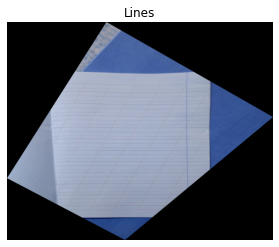

In [19]:
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_new_1)

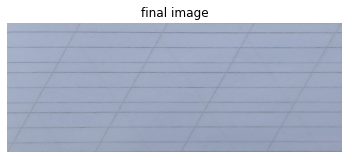

In [20]:
plt.clf()
plt.axis("off")
plt.title("final image")
plt.imshow(img_new_2)